# Spaceship Titanic Competition 
### Predicting wich passengers got transported to another dimension 
------------------------

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## The Dataset
------------
### Describing the columns
* **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* **Destination** - The planet the passenger will be debarking to.
* **Age** - The age of the passenger.
* **VIP** - Whether the passenger has paid for special VIP service during the voyage.
* **RoomService**, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* **Name** - The first and last names of the passenger.
* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Importing the Data

In [2]:
# reading data
train_dataset = pd.read_csv('data/train.csv')
test_dataset = pd.read_csv('data/test.csv')

# creating dataframe to work on 
df_train = train_dataset.copy()
df_test = test_dataset.copy()

# datasets shape
print('Training dataset shape:', df_train.shape)
print('Testing dataset shape:', df_test.shape)

Training dataset shape: (8693, 14)
Testing dataset shape: (4277, 13)


## Basic Data Understanding

In [3]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


**observation**
- Most people didn't spend mony on the spaceship amenities, since the median for those 4 variables is 0

In [6]:
df_train.describe(include=['object', 'bool']).T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2
Transported,8693,2,True,4378


## Data Cleaning

### 1. Adjusting the passenger_id and the cabin features to be more generalist
- As we know, the first four digits in the passenger_id refers to the group that passenger was travelling, so let's create a now column containing only those groups.
- The Cabin feature is divided in 3 parts: deck/num/side. 
    - Both the deck and the side can lead to usefull information, so i'll create an specific column for each of them

**PassengerId**

In [7]:
df_train['PassengerGroup'] = [value[0:4] for value in df_train['PassengerId'].values]
df_train['PassengerGroup'].unique().size

6217

- As we can see, there are 6217 different passenger groups in the ship. So it doesn't have any predictive power. 
- I'll just remove both columns.

In [8]:
df_train.drop(['PassengerId', 'PassengerGroup'], axis=1, inplace=True)
df_train.head(1)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False


**Cabin**

In [9]:
df_train['PassengerDeck'] = df_train.Cabin.str[0]
df_train['PassengerSide'] = df_train.Cabin.str[-1]
print(df_train['PassengerDeck'].value_counts())
print('\n'+'-'*50)
print(df_train['PassengerSide'].value_counts())

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: PassengerDeck, dtype: int64

--------------------------------------------------
S    4288
P    4206
Name: PassengerSide, dtype: int64


- There are 8 different decks in the ship, two of them with much more passengers than the rest. This column will more interfere than help, so I'll remove it, along with the Cabin column.
- Both sides of the ship have very similar number of passengers, so I'll keep this column

In [10]:
df_train.drop(['Cabin', 'PassengerDeck'], axis=1, inplace=True)
df_train.head(1)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,P


### 2. Dropping the most useless column: Name

In [11]:
df_train.drop('Name', axis=1, inplace=True)

### 3. Dealing with null values

In [12]:
df_train.isnull().sum()

HomePlanet       201
CryoSleep        217
Destination      182
Age              179
VIP              203
RoomService      181
FoodCourt        183
ShoppingMall     208
Spa              183
VRDeck           188
Transported        0
PassengerSide    199
dtype: int64

In [13]:
df_train.isnull().sum()*100/len(df_train)

HomePlanet       2.312205
CryoSleep        2.496261
Destination      2.093639
Age              2.059128
VIP              2.335212
RoomService      2.082135
FoodCourt        2.105142
ShoppingMall     2.392730
Spa              2.105142
VRDeck           2.162660
Transported      0.000000
PassengerSide    2.289198
dtype: float64

- Basically every column has null values, so:
    - For the 'object' type colums: replace with the column mode
    - For the 'float64' type columns: replace with the median 

In [14]:
# null analysis function

def column_nulls_analysis(df):
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            print('\nColumn: '+column)
            if df[column].dtype == 'O' or df[column].dtype == 'bool':
                print('\nValue Counts:')
                print(df[column].value_counts())
                print('\nValue that will replace the nulls:',df[column].mode().loc[0])
                print('-'*50)
            elif df[column].dtype == 'float64':
                print(f'\nColumn Mean:{df[column].mean()}')
                print(f'Column Median: {df[column].median()}')
                print(f'Column Max: {df[column].max()}')
                print(f'Column Min: {df[column].min()}')
                print('-'*50)
            
print(column_nulls_analysis(df_train))


Column: HomePlanet

Value Counts:
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

Value that will replace the nulls: Earth
--------------------------------------------------

Column: CryoSleep

Value Counts:
False    5439
True     3037
Name: CryoSleep, dtype: int64

Value that will replace the nulls: False
--------------------------------------------------

Column: Destination

Value Counts:
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

Value that will replace the nulls: TRAPPIST-1e
--------------------------------------------------

Column: Age

Column Mean:28.82793046746535
Column Median: 27.0
Column Max: 79.0
Column Min: 0.0
--------------------------------------------------

Column: VIP

Value Counts:
False    8291
True      199
Name: VIP, dtype: int64

Value that will replace the nulls: False
--------------------------------------------------

Column: RoomService

Column Mean:224.687617481203
Column

In [15]:
# null filler function
def null_filler(df):
    """replace the null values of the dataframe"""
    for col in df.columns:
        if df[col].dtype == 'O' or df[col].dtype == 'bool':
            df[col].fillna(df[col].mode().loc[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
        
null_filler(df_train)

df_train.isnull().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Transported      0
PassengerSide    0
dtype: int64

- Null values have been removed

### 4. Making the same changes on the test dataset

In [16]:
df_test.drop(['PassengerId'], axis=1, inplace=True)
df_test['PassengerSide'] = df_test.Cabin.str[-1]
df_test.drop(['Cabin'], axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)
null_filler(df_test)
display(df_test.head(1))

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerSide
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,S


## Exploratory Data Analysis

### 1. Univariate Analysis

**Home Planet**

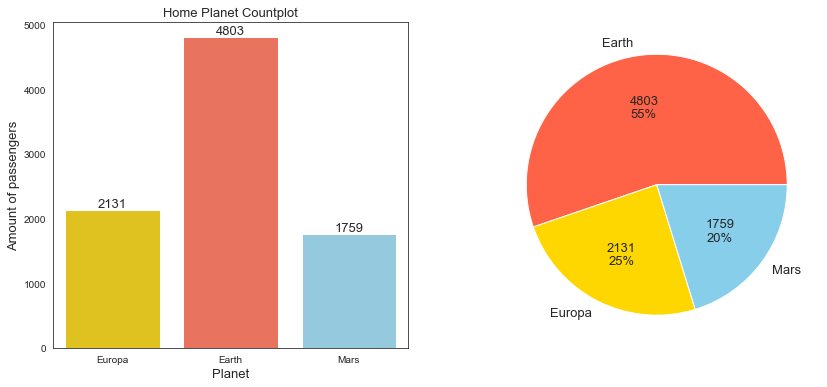

In [34]:
def label_function(val):
    return f'{val / 100 * len(df_train):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# bar plot 
sns.countplot(ax=ax1, data=df_train, x='HomePlanet', palette=['gold', 'tomato', 'skyblue'])
ax1.set_title('Home Planet Countplot', size=13)
ax1.set_ylabel('Amount of passengers', size=13)
ax1.set_xlabel('Planet', size=13)

#annotating on bar plot
for x in ax1.containers:
    ax1.bar_label(x, size=13)

# pie plot
df_train.groupby(['HomePlanet']).size().plot(kind='pie', ax=ax2, autopct=label_function, 
                                             labels=df_train.HomePlanet.value_counts().index,
                                             textprops={'fontsize': 13}, colors=['tomato', 'gold', 'skyblue'])
ax2.set_ylabel('')

plt.show()

**insights**
- Most people came from earth. 
- Europa is more popular than mars

**CryoSleep**

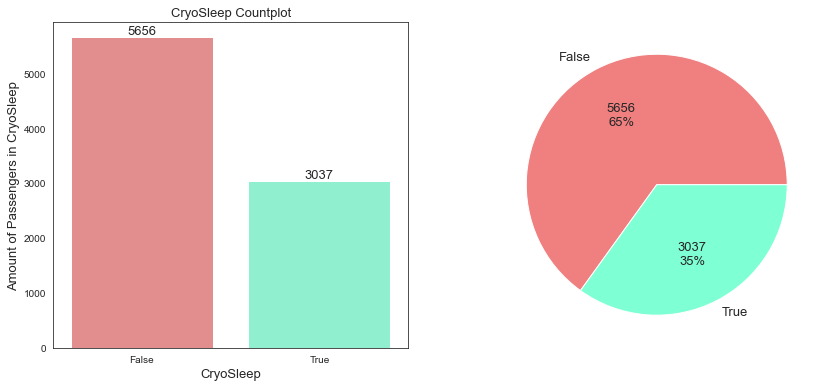

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# bar plot
sns.countplot(x='CryoSleep', data=df_train, ax=ax1, palette=['lightcoral', 'aquamarine'])
ax1.set_ylabel('Amount of Passengers in CryoSleep', size=13)
ax1.set_xlabel('CryoSleep', size=13)
ax1.set_title('CryoSleep Countplot', size=13)
for x in ax1.containers:
    ax1.bar_label(x, size=13)

# pie plot
df_train.groupby('CryoSleep').size().plot(kind='pie', ax=ax2, autopct=label_function, 
                                          labels=df_train.CryoSleep.value_counts().index,
                                          textprops={'fontsize':13}, colors=['lightcoral', 'aquamarine'])
ax2.set_ylabel('')

plt.show()

**insights**
- Most passengers (65%) are not in cryosleep

**Destination**

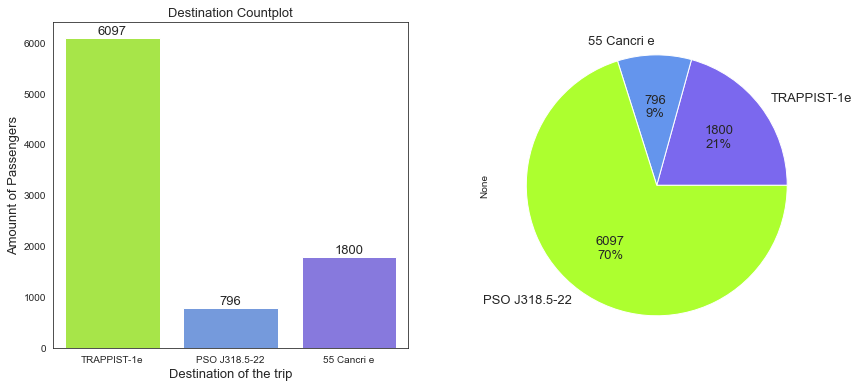

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# bar plot
sns.countplot(x='Destination', data=df_train, ax=ax1, palette=['greenyellow', 'cornflowerblue', 'mediumslateblue'])
ax1.set_ylabel('Amounnt of Passengers', size=13)
ax1.set_xlabel('Destination of the trip', size=13)
ax1.set_title('Destination Countplot', size=13)

for x in ax1.containers:
    ax1.bar_label(x, size=13)

# pie plot
df_train.groupby('Destination').size().plot(kind='pie', ax=ax2, autopct=label_function, 
                                            labels=df_train.Destination.value_counts().index,
                                            textprops={'fontsize':13}, colors=['mediumslateblue', 'cornflowerblue', 'greenyellow'])

plt.show()

**insights**
- 'TRAPPIST-1e' is the most popular destination, with 70% of passengers 

**Vip**

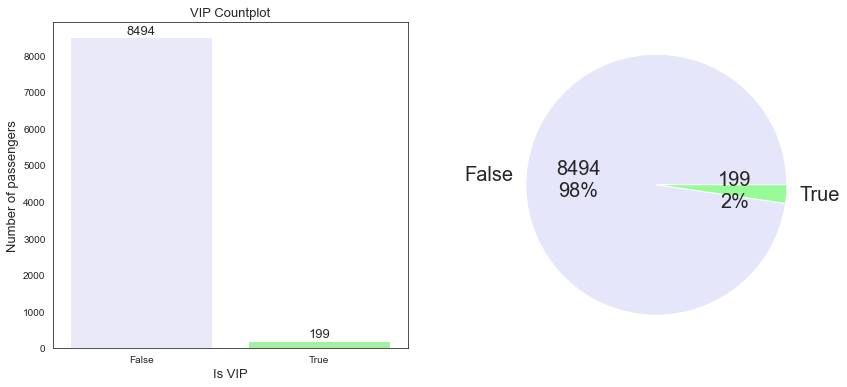

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# bar plot
sns.countplot(x='VIP', data=df_train, ax=ax1, palette=['lavender', 'palegreen'])
ax1.set_ylabel('Number of passengers', size=13)
ax1.set_xlabel('Is VIP', size=13)
ax1.set_title('VIP Countplot', size=13)
for x in ax1.containers:
    ax1.bar_label(x, size=13)

# pie plot
df_train.groupby('VIP').size().plot(kind='pie', ax=ax2, autopct=label_function,
                                    labels=df_train.VIP.value_counts().index, 
                                    textprops={'fontsize':20}, colors=['lavender', 'palegreen'])
ax2.set_ylabel('')

plt.show()

**insights**
- The big majority of passengers wans't considered VIP
    - which is kind obvious, if everyone is VIP, no one is VIP

**Passenger Side**

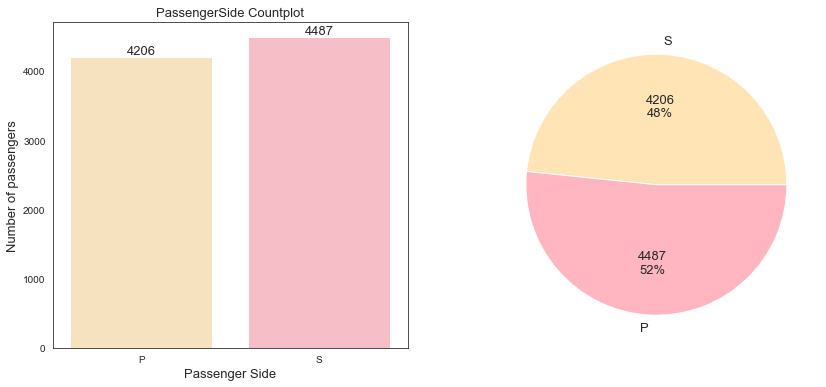

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# bar plot
sns.countplot(x='PassengerSide', data=df_train, ax=ax1, palette=['moccasin', 'lightpink'])
ax1.set_ylabel('Number of passengers', size=13)
ax1.set_xlabel('Passenger Side', size=13)
ax1.set_title('PassengerSide Countplot', size=13)
for x in ax1.containers:
    ax1.bar_label(x, size=13)

# pie plot
df_train.groupby('PassengerSide').size().plot(kind='pie', ax=ax2, autopct=label_function,
                                    labels=df_train.PassengerSide.value_counts().index, 
                                    textprops={'fontsize':13}, colors=['moccasin', 'lightpink'])
ax2.set_ylabel('')

plt.show()

**insights**
- There amount of passengers on each side is very similar

**Transported**

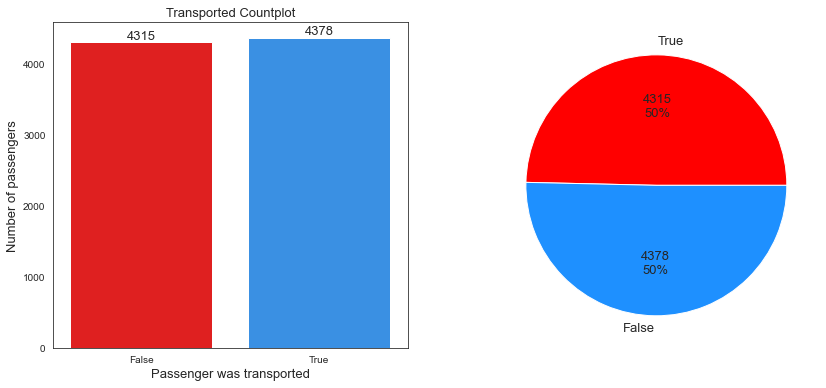

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# bar plot
sns.countplot(x='Transported', data=df_train, ax=ax1, palette=['r', 'dodgerblue'])
ax1.set_ylabel('Number of passengers', size=13)
ax1.set_xlabel('Passenger was transported', size=13)
ax1.set_title('Transported Countplot', size=13)
for x in ax1.containers:
    ax1.bar_label(x, size=13)

# pie plot
df_train.groupby('Transported').size().plot(kind='pie', ax=ax2, autopct=label_function,
                                    labels=df_train.Transported.value_counts().index, 
                                    textprops={'fontsize':13}, colors=['r', 'dodgerblue'])
ax2.set_ylabel('')

plt.show()

**insights**
- The amount of passengers that got transported is very simlar to the amount of passengers who wans't 